<a href="https://colab.research.google.com/github/raplima/2020_cores_auto/blob/master/scripts/eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone repository
!git clone https://github.com/raplima/2020_cores_auto.git

Cloning into '2020_cores_auto'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 433 (delta 75), reused 77 (delta 18), pack-reused 271
Receiving objects: 100% (433/433), 56.76 MiB | 19.57 MiB/s, done.
Resolving deltas: 100% (221/221), done.


In [2]:
import os

import json
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
# count the instances
data_dir = '/content/2020_cores_auto/data'
folds_jsons = sorted(ii for ii in os.listdir(data_dir) if 'fold' in ii)

print(f'{"fold":8s} {"dset":9} {" #figures":10s} {" #instances":16s}')
for ii in folds_jsons:
    # read the metrics json file
    json_file = os.path.join(data_dir, ii)
    with open(json_file) as f:
        folds_dict = json.load(f)
    instances_in = sum(len(folds_dict[k]['regions']) for k in folds_dict.keys())
    fold = ii.split("_")[2]
    dset = ii.split("_")[3].split('.')[0]
    print(f'{fold:8s} {dset:8s} {len(folds_dict):10d} {instances_in:12}')


fold     dset       #figures   #instances     
0        train            56          543
0        val              15          113
1        train            57          493
1        val              14          163
2        train            57          551
2        val              14          105
3        train            57          543
3        val              14          113
4        train            57          494
4        val              14          162


In [4]:
# list the folders
results_root = '/content/2020_cores_auto/data/results/'

dfs = {}
dfs_ap = {}
for dir in os.listdir(results_root):
    results_dir = os.path.join(results_root, dir)
    out_folders = sorted(os.listdir(results_dir))

    # create dataframe
    metrics = []
    for dd in out_folders:
        fold = dd.split('_')[-1]
        # read the metrics json file
        json_file = os.path.join(results_dir, dd, 'metrics.json')
        with open(json_file) as f:
            for line in f:
                metrics.append(json.loads(line)) 
                metrics[-1]['fold'] = fold
                # clean up cores_fold_{fold}_train/ and cores_fold_{fold}_val/
                keys_to_clean = [k for k in metrics[-1] if 'cores_fold' in k]
                for k in keys_to_clean:
                    new_key = k.split('_', -1)[-1]
                    metrics[-1][new_key] = metrics[-1].pop(k)
    df = pd.DataFrame(metrics)                
    dfs[dir] = df.copy()

    # create the AP metrics dataframe (this is very similar to the above)
    # be careful with repeated variables:
    metrics = []
    for dd in out_folders:
        fold = dd.split('_')[-1]
        for dset in ['train', 'val']:
            # read the metrics json file
            json_file = os.path.join(results_dir, dd, f'cocoeval_{dset}_{fold}.json')
            with open(json_file) as f:
                metrics.append(json.load(f)['segm']) 
            metrics[-1]['fold'] = fold
            metrics[-1]['set'] = dset
    df = pd.DataFrame(metrics)      
    df = df.drop(labels=['APs', 'APm', 'APl'], axis=1)      
    dfs_ap[dir] = df.copy()


# list of experiments/dictionary keys
exps = ['R50-C4', 'R50-FPN']
models = ['ResNet50-C4', 'ResNet50-FPN']
for exp, mod in zip(exps, models):
    dfs[exp]['Model'] = mod
    dfs_ap[exp]['Model'] = mod
# combine dfs into a single one
df = pd.concat(dfs, ignore_index=True)
df_ap = pd.concat(dfs_ap, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


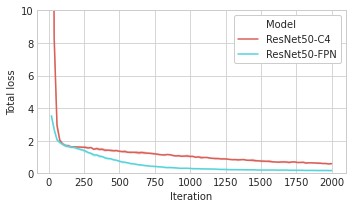

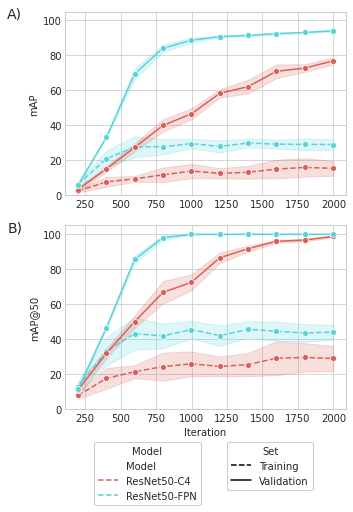

In [5]:
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

with plt.style.context('seaborn-whitegrid'):
    rcParams['font.sans-serif'] = ['Tahoma']
    rcParams['legend.framealpha'] = 1.0
    rcParams['legend.frameon'] = True
    palette = sns.color_palette("hls", len(df['Model'].unique()))

    ############################################################################
    ############################################################################
    # first fig
    fig, ax = plt.subplots(ncols=1, figsize=(5,3))
    sns.lineplot(x="iteration", y="total_loss", hue='Model', ci='sd', 
                 palette=palette, 
                 data=df,
                 ax=ax)
    #ax.set_xlim(0,np.max(df['iteration'])+10)
    ax.set_ylim(0,10)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Total loss')

    fig.tight_layout()
    fig.savefig('/content/training_loss.pdf')

    ############################################################################
    ############################################################################
    # second fig
    fig, ax = plt.subplots(2, figsize=(5,7))
    sns.lineplot(x="iteration", y="val/segm/AP", hue='Model', ci='sd', 
                 marker='o', palette=palette, legend = False, 
                 data=df, ax=ax[0])  

    sns.lineplot(x="iteration", y="val/segm/AP50", hue='Model', ci='sd', 
                 marker='o', palette=palette,
                 data=df, ax=ax[1])
    
    # change the dashes:
    [ax[0].lines[ii].set_linestyle("--") for ii, _ in enumerate(ax[0].lines)]    
    [ax[1].lines[ii].set_linestyle("--") for ii, _ in enumerate(ax[1].lines)]        

    sns.lineplot(x="iteration", y="train/segm/AP", hue='Model', ci='sd', 
                 marker='o', palette=palette, 
                 legend=False, 
                 data=df, ax=ax[0])
    ax[0].set_xlabel('')
    ax[0].set_ylabel('mAP')
    #ax[0].set_xlim(0,np.max(df['iteration'])+10)    
    ax[0].set_ylim(0,105) 

    sns.lineplot(x="iteration", y="train/segm/AP50", hue='Model', ci='sd', 
                 marker='o', palette=palette, 
                 legend=False,
                 data=df, ax=ax[1])
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('mAP@50')
    #ax[1].set_xlim(0,np.max(df['iteration'])+10) 
    ax[1].set_ylim(0,105)

    # add letters:
    for ii, l in enumerate(['A)', 'B)']):
        ax[ii].text(-300, 100,
                    s=l, 
                    bbox=dict(facecolor='white', edgecolor='white', alpha=1), 
                    ha='left', va='bottom', size=14)

    # fix the legends
    handles, labels = ax[0].get_legend_handles_labels()
    
    legend_x = 0.5
    legend_y = -0.15
    
    leg1 = ax[1].legend(handles=handles, labels=labels, 
              bbox_to_anchor=(legend_x, legend_y),
              title="Model")

    legend_x = 0.9
    legend_y = -0.15

    custom_lines = [Line2D([0], [0], color='k', ls="--"),
                    Line2D([0], [0], color='k', ls="-")]
    ax[1].legend(custom_lines, ['Training', 'Validation'], 
              bbox_to_anchor=(legend_x, legend_y),
              title='Set')
    ax[1].add_artist(leg1)        
    
    fig.tight_layout()
    fig.savefig('/content/training_aps.svg')

In [6]:
# create dataframe
metrics = []
for dd in out_folders:
    fold = dd.split('_')[-1]
    for dset in ['train', 'val']:
        # read the metrics json file
        json_file = os.path.join(results_dir, dd, f'cocoeval_{dset}_{fold}.json')
        with open(json_file) as f:
            metrics.append(json.load(f)['segm']) 
        metrics[-1]['fold'] = fold
        metrics[-1]['set'] = dset
df = pd.DataFrame(metrics)      
df = df.drop(labels=['APs', 'APm', 'APl'], axis=1)      

In [7]:
df_ap.groupby(['Model', 'set']).describe()[['AP', 'AP75', 'AP50']].T

Model      ResNet50-C4            ResNet50-FPN           
set              train        val        train        val
AP   count    5.000000   5.000000     5.000000   5.000000
     mean    76.838922  15.445938    94.013718  29.046451
     std      2.021833   4.262126     0.521930   2.985862
     min     74.047342   9.822572    93.559688  25.675847
     25%     75.400809  13.021208    93.661987  28.174086
     50%     77.667941  15.930756    93.872087  28.601558
     75%     78.437828  17.449276    94.105998  28.905072
     max     78.640693  21.005876    94.868828  33.875692
AP75 count    5.000000   5.000000     5.000000   5.000000
     mean    92.107322  15.354107    99.972245  30.717381
     std      1.724482   4.359424     0.032296   5.203952
     min     90.326583   8.841097    99.922033  26.201539
     25%     90.419063  12.934727    99.959440  28.344977
     50%     92.172187  17.476979    99.982986  29.122693
     75%     93.614678  18.594165    99.996767  30.280163
     max     94.004102  18.923566   100.000000  39.637535
AP50 count    5.000000   5.000000     5.000000   5.000000
     mean    98.717895  28.978689    99.972245  44.084795
     std      0.555983   7.260610     0.032296   4.257121
     min     97.814049  19.746759    99.922033  40.954894
     25%     98.610628  26.304073    99.959440  41.119084
     50%     98.904699  28.019463    99.982986  42.619043
     75%     99.000856  31.240273    99.996767  44.462167
     max     99.259245  39.582879   100.000000  51.268789

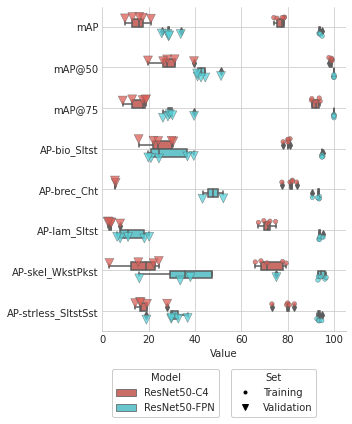

In [8]:
# "Melt" the dataset to "long-form" or "tidy" representation
melted = pd.melt(df_ap, ["Model", "set", "fold"])
melted = melted.replace('AP', 'mAP')
melted = melted.replace('AP50', 'mAP@50')
melted = melted.replace('AP75', 'mAP@75')

with plt.style.context('seaborn-whitegrid'):    
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Tahoma']
    rcParams['legend.framealpha'] = 1.0
    rcParams['legend.frameon'] = True
    # first fig
    fig, ax = plt.subplots(1, figsize=(5,6))

    for dset, mark in zip(['train', 'val'], ['.', 'v']):
        sns.boxplot(x="value", y="variable", hue="Model",
                    dodge=True, width=0.4, palette=palette,
                    data=melted.loc[melted['set'] == dset],
                    ax=ax)
        
    # Show each observation with a scatterplot
        sns.stripplot(x="value", y="variable", hue="Model", 
                      marker = mark,
                    linewidth=0.5, size=9, palette=palette,
                    data=melted.loc[melted['set'] == dset], 
                    dodge=True, 
                     alpha=.75,
                    ax=ax)
    
    ax.set_xlabel('Value')
    ax.set_xlim(0, 105)
    ax.set_ylabel('')
    ax.grid(True)

    # Improve the legend 
    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    
    legend_x = 0.5
    legend_y = -0.1
    
    leg1 = ax.legend(handles=handles[:3], labels=models, 
              bbox_to_anchor=(legend_x, legend_y),
              title="Model")

    legend_x = 0.9
    legend_y = -0.1

    custom_lines = [Line2D([0], [0], color='k', ls='None', marker='.'),
                    Line2D([0], [0], color='k', ls='None', marker='v')]
    ax.legend(custom_lines, ['Training', 'Validation'], 
              bbox_to_anchor=(legend_x, legend_y),
              title='Set')
    ax.add_artist(leg1)

    for l in ['right', 'left', 'top']:
        ax.spines[l].set_visible(False)

    fig.tight_layout()
    fig.savefig('/content/aps.pdf')

In [9]:
# download, decompress the data
!gdown https://drive.google.com/uc?id=1n6w9DJmrcepwIvWsJXLhAxAbHM0f2XjR
!unzip cores.zip > /dev/null

# download class json from github
!wget https://raw.githubusercontent.com/raplima/2020_cores_auto/master/data/classes.json
!mv classes.json cores

# download class colors json from github
!wget https://raw.githubusercontent.com/raplima/2020_cores_auto/master/data/colors_dict.json
!mv colors_dict.json cores

!cp 2020_cores_auto/data/cores* cores

Downloading...
From: https://drive.google.com/uc?id=1n6w9DJmrcepwIvWsJXLhAxAbHM0f2XjR
To: /content/cores.zip
296MB [00:02, 113MB/s]
--2020-07-15 15:28:00--  https://raw.githubusercontent.com/raplima/2020_cores_auto/master/data/classes.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223 [text/plain]
Saving to: ‘classes.json’

classes.json        100%[===================>]     223  --.-KB/s    in 0s      

2020-07-15 15:28:00 (14.9 MB/s) - ‘classes.json’ saved [223/223]

--2020-07-15 15:28:03--  https://raw.githubusercontent.com/raplima/2020_cores_auto/master/data/colors_dict.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.

In [10]:
import os
import json
import cv2

import numpy as np

# modify data loading so it is not dependent on detectron
def get_data_dicts(img_dir, dict_json):
    """
    function to format the data into detectron2 input parameters
    Parameters
    ----------
    img_dir : string
        path to folder with images and a "classes.json" dictionary.
    dict_json : dict
        a dictionary containing image info.
    Returns
    -------
    dataset_dicts : dict
        the dictionary used as input to detectron2 model
    """
    # get the classes:
    json_file = os.path.join(img_dir, "classes.json")
    with open(json_file) as f:
        ann_classes = json.load(f)
    # transform the dictionary into a list 
    classes=sorted([it for _, it in ann_classes.items()])

    json_file = os.path.join(img_dir, dict_json)
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for anno in annos:
            #assert not anno["region_attributes"]
            region = anno['region_attributes']
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                #"bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(ann_classes[region['lithofacies']]),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [11]:
def plot_res (samp, im, patch_dict, thing_classes):
    """
    function to plot results
    Parameters
    ----------
    samp : dictionary
        one sample from the (detectron2) Dataset
    im : numpy array
        the image (read by cv2) from samp
    patch_dict : dictionary
        a dictionary containing color (perhaps patch) info for the classes.
    thing_classes : list
        a list of classes
    Returns
    -------
    fig : matplotlib figure
        the figure built by this function
    """
    im = cv2.imread(samp['file_name'])

    fig, ax = plt.subplots(ncols=2, figsize=(7.5,4.5))
    ax[0].imshow(im)
    ax[1].imshow(im)

    ax[0].set_axis_off()
    ax[1].set_axis_off()

    ax[0].set_title('Input image')
    ax[1].set_title('Interpretation')

    # add letters:
    for ii, l in enumerate('AB'):
        ax[ii].text(0, 0,
                    s=l, 
                    bbox=dict(facecolor='white', alpha=1), 
                    ha='left', va='bottom', size=14)
        
    # add colors:
    jj = 250
    for k in patch_dict:
        ax[1].text(im.shape[1]+100, jj,
                    s=k, 
                    bbox=dict(facecolor=patch_dict[k]['color'], alpha=0.7), 
                    ha='left', va='bottom', size=14)
        jj += 400


    for annot in samp['annotations']:
        # select the x and y segmentation points
        segx = annot['segmentation'][0][0::2]
        segy = annot['segmentation'][0][1::2]
        ax[1].fill(segx, segy, patch_dict[thing_classes[annot['category_id']]]['color'], alpha=0.8)

    return fig

In [12]:
data_dir = 'cores'
# read the classes dictionary
json_file = os.path.join(data_dir, "classes.json")
with open(json_file) as f:
    classes = json.load(f)

# save a list with same format as function and metadata:
thing_classes = sorted([it for _, it in classes.items()])

# read the colors dictionary
json_file = os.path.join(data_dir, "colors_dict.json")
with open(json_file) as f:
    patch_dict = json.load(f)  

# set the data dictionary
data_list = get_data_dicts(data_dir, 'cores_fold_0_train.json')

selected cores/Box 2 Depths 7735-7745 (Dry).JPG


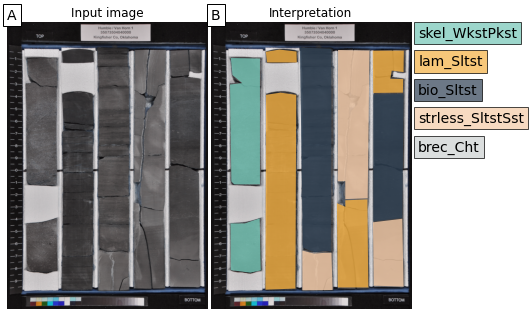

In [13]:
samp = data_list[0]
print(f"selected {samp['file_name']}")
im = cv2.imread(samp['file_name'])
fig = plot_res(samp, im, patch_dict, thing_classes)

fig.tight_layout()
fig.savefig('example_interpretation_1.pdf', dpi=800)

In [ ]:
samp = data_list[9]
print(f"selected {samp['file_name']}")
im = cv2.imread(samp['file_name'])
fig = plot_res(samp, im, patch_dict, thing_classes)

fig.tight_layout()
fig.savefig('example_interpretation_2.pdf', dpi=800)

selected cores/Box 12 Depths 7835-7845.JPG
